#Implementation of Block Neural Autoregressive Flow
http://arxiv.org/abs/1904.04676

Implementation adapted from:
https://github.com/nicola-decao/BNAF
and
https://github.com/kamenbliznashki/normalizing_flows


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset

import math
import os
import time
import argparse
import pprint
from functools import partial

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data

### Energy potential functions for density matching

In [2]:
def potential_fn(dataset):
    # NF paper table 1 energy functions
    w1 = lambda z: torch.sin(2 * math.pi * z[:,0] / 4)
    w2 = lambda z: 3 * torch.exp(-0.5 * ((z[:,0] - 1)/0.6)**2)
    w3 = lambda z: 3 * torch.sigmoid((z[:,0] - 1) / 0.3)

    if dataset == 'u1':
        return lambda z: 0.5 * ((torch.norm(z, p=2, dim=1) - 2) / 0.4)**2 - \
                                torch.log(torch.exp(-0.5*((z[:,0] - 2) / 0.6)**2) + \
                                          torch.exp(-0.5*((z[:,0] + 2) / 0.6)**2) + 1e-10)

    elif dataset == 'u2':
        return lambda z: 0.5 * ((z[:,1] - w1(z)) / 0.4)**2

    elif dataset == 'u3':
        return lambda z: - torch.log(torch.exp(-0.5*((z[:,1] - w1(z))/0.35)**2) + \
                                     torch.exp(-0.5*((z[:,1] - w1(z) + w2(z))/0.35)**2) + 1e-10)

    elif dataset == 'u4':
        return lambda z: - torch.log(torch.exp(-0.5*((z[:,1] - w1(z))/0.4)**2) + \
                                     torch.exp(-0.5*((z[:,1] - w1(z) + w3(z))/0.35)**2) + 1e-10)

    else:
        raise RuntimeError('Invalid potential name to sample from.')

### Sampling distributions for density estimation

In [3]:
def sample_2d_data(dataset, n_samples):

    z = torch.randn(n_samples, 2)

    if dataset == '8gaussians':
        scale = 4
        sq2 = 1/math.sqrt(2)
        centers = [(1,0), (-1,0), (0,1), (0,-1), (sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
        centers = torch.tensor([(scale * x, scale * y) for x,y in centers])
        return sq2 * (0.5 * z + centers[torch.randint(len(centers), size=(n_samples,))])

    elif dataset == '2spirals':
        n = torch.sqrt(torch.rand(n_samples // 2)) * 540 * (2 * math.pi) / 360
        d1x = - torch.cos(n) * n + torch.rand(n_samples // 2) * 0.5
        d1y =   torch.sin(n) * n + torch.rand(n_samples // 2) * 0.5
        x = torch.cat([torch.stack([ d1x,  d1y], dim=1),
                       torch.stack([-d1x, -d1y], dim=1)], dim=0) / 3
        return x + 0.1*z

    elif dataset == 'checkerboard':
        x1 = torch.rand(n_samples) * 4 - 2
        x2_ = torch.rand(n_samples) - torch.randint(0, 2, (n_samples,), dtype=torch.float) * 2
        x2 = x2_ + x1.floor() % 2
        return torch.stack([x1, x2], dim=1) * 2

    elif dataset == 'rings':
        n_samples4 = n_samples3 = n_samples2 = n_samples // 4
        n_samples1 = n_samples - n_samples4 - n_samples3 - n_samples2

        # so as not to have the first point = last point, set endpoint=False in np; here shifted by one
        linspace4 = torch.linspace(0, 2 * math.pi, n_samples4 + 1)[:-1]
        linspace3 = torch.linspace(0, 2 * math.pi, n_samples3 + 1)[:-1]
        linspace2 = torch.linspace(0, 2 * math.pi, n_samples2 + 1)[:-1]
        linspace1 = torch.linspace(0, 2 * math.pi, n_samples1 + 1)[:-1]

        circ4_x = torch.cos(linspace4)
        circ4_y = torch.sin(linspace4)
        circ3_x = torch.cos(linspace4) * 0.75
        circ3_y = torch.sin(linspace3) * 0.75
        circ2_x = torch.cos(linspace2) * 0.5
        circ2_y = torch.sin(linspace2) * 0.5
        circ1_x = torch.cos(linspace1) * 0.25
        circ1_y = torch.sin(linspace1) * 0.25

        x = torch.stack([torch.cat([circ4_x, circ3_x, circ2_x, circ1_x]),
                         torch.cat([circ4_y, circ3_y, circ2_y, circ1_y])], dim=1) * 3.0

        # random sample
        x = x[torch.randint(0, n_samples, size=(n_samples,))]

        # Add noise
        return x + torch.normal(mean=torch.zeros_like(x), std=0.08*torch.ones_like(x))

    else:
        raise RuntimeError('Invalid `dataset` to sample from.')

## Model components

In [4]:
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, data_dim):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.data_dim = data_dim

        # Notation:
        # BNAF weight calculation for (eq 8): W = g(W) * M_d + W * M_o
        #   where W is block lower triangular so model is autoregressive,
        #         g = exp function; M_d is block diagonal mask; M_o is block off-diagonal mask.
        # Weight Normalization (Salimans & Kingma, eq 2): w = g * v / ||v||
        #   where g is scalar, v is k-dim vector, ||v|| is Euclidean norm
        # ------
        # Here: pre-weight norm matrix is v; then: v = exp(weight) * mask_d + weight * mask_o
        #       weight-norm scalar is g: out_features dimensional vector (here logg is used instead to avoid taking logs in the logdet calc.
        #       then weight-normed weight matrix is w = g * v / ||v||
        #
        #       log det jacobian of block lower triangular is taking block diagonal mask of
        #           log(g*v/||v||) = log(g) + log(v) - log(||v||)
        #                          = log(g) + weight - log(||v||) since v = exp(weight) * mask_d + weight * mask_o

        weight = torch.zeros(out_features, in_features)
        mask_d = torch.zeros_like(weight)
        mask_o = torch.zeros_like(weight)
        for i in range(data_dim):
            # select block slices
            h     = slice(i * out_features // data_dim, (i+1) * out_features // data_dim)
            w     = slice(i * in_features // data_dim,  (i+1) * in_features // data_dim)
            w_row = slice(0,                            (i+1) * in_features // data_dim)
            # initialize block-lower-triangular weight and construct block diagonal mask_d and lower triangular mask_o
            nn.init.kaiming_uniform_(weight[h,w_row], a=math.sqrt(5))  # default nn.Linear weight init only block-wise
            mask_d[h,w] = 1
            mask_o[h,w_row] = 1

        mask_o = mask_o - mask_d  # remove diagonal so mask_o is lower triangular 1-off the diagonal

        self.weight = nn.Parameter(weight)                          # pre-mask, pre-weight-norm
        self.logg = nn.Parameter(torch.rand(out_features, 1).log()) # weight-norm parameter
        self.bias = nn.Parameter(nn.init.uniform_(torch.rand(out_features), -1/math.sqrt(in_features), 1/math.sqrt(in_features)))  # default nn.Linear bias init
        self.register_buffer('mask_d', mask_d)
        self.register_buffer('mask_o', mask_o)

    def forward(self, x, sum_logdets):
        # 1. compute BNAF masked weight eq 8
        v = self.weight.exp() * self.mask_d + self.weight * self.mask_o
        # 2. weight normalization
        v_norm = v.norm(p=2, dim=1, keepdim=True)
        w = self.logg.exp() * v / v_norm
        # 3. compute output and logdet of the layer
        out = F.linear(x, w, self.bias)
        logdet = self.logg + self.weight - 0.5 * v_norm.pow(2).log()
        logdet = logdet[self.mask_d.byte()]
        logdet = logdet.view(1, self.data_dim, out.shape[1]//self.data_dim, x.shape[1]//self.data_dim) \
                       .expand(x.shape[0],-1,-1,-1)  # output (B, data_dim, out_dim // data_dim, in_dim // data_dim)

        # 4. sum with sum_logdets from layers before (BNAF section 3.3)
        # Compute log det jacobian of the flow (eq 9, 10, 11) using log-matrix multiplication of the different layers.
        # Specifically for two successive MaskedLinear layers A -> B with logdets A and B of shapes
        #  logdet A is (B, data_dim, outA_dim, inA_dim)
        #  logdet B is (B, data_dim, outB_dim, inB_dim) where outA_dim = inB_dim
        #
        #  Note -- in the first layer, inA_dim = in_features//data_dim = 1 since in_features == data_dim.
        #            thus logdet A is (B, data_dim, outA_dim, 1)
        #
        #  Then:
        #  logsumexp(A.transpose(2,3) + B) = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, inB_dim) , dim=-1)
        #                                  = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, outA_dim), dim=-1)
        #                                  = logsumexp( (B, data_dim, outB_dim, outA_dim), dim=-1) where dim2 of tensor1 is broadcasted
        #                                  = (B, data_dim, outB_dim, 1)

        sum_logdets = torch.logsumexp(sum_logdets.transpose(2,3) + logdet, dim=-1, keepdim=True)

        return out, sum_logdets


    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

class Tanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, sum_logdets):
        # derivation of logdet:
        # d/dx tanh = 1 / cosh^2; cosh = (1 + exp(-2x)) / (2*exp(-x))
        # log d/dx tanh = - 2 * log cosh = -2 * (x - log 2 + log(1 + exp(-2x)))
        logdet = -2 * (x - math.log(2) + F.softplus(-2*x))
        sum_logdets = sum_logdets + logdet.view_as(sum_logdets)
        return x.tanh(), sum_logdets

class FlowSequential(nn.Sequential):
    """ Container for layers of a normalizing flow """
    def forward(self, x):
        sum_logdets = torch.zeros(1, x.shape[1], 1, 1, device=x.device)
        for module in self:
            x, sum_logdets = module(x, sum_logdets)
        return x, sum_logdets.squeeze()


## Model

In [5]:
class BNAF(nn.Module):
    def __init__(self, data_dim, n_hidden, hidden_dim):
        super().__init__()

        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(data_dim))
        self.register_buffer('base_dist_var', torch.ones(data_dim))

        # construct model
        modules = []
        modules += [MaskedLinear(data_dim, hidden_dim, data_dim), Tanh()]
        for _ in range(n_hidden):
            modules += [MaskedLinear(hidden_dim, hidden_dim, data_dim), Tanh()]
        modules += [MaskedLinear(hidden_dim, data_dim, data_dim)]
        self.net = FlowSequential(*modules)

        # TODO --   add permutation
        #           add residual gate
        #           add stack of flows

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x):
        return self.net(x)

def compute_kl_qp_loss(model, target_potential_fn, batch_size):
    """ Compute BNAF eq 3 & 20:
    KL(q_inv||p) where q_inv is the inverse flow transform (log_q_inv = log_q_base - logdet), p is the target distribution (energy potential)
    Returns the minimization objective for density matching. """
    z = model.base_dist.sample((batch_size,))
    q_log_prob = model.base_dist.log_prob(z)
    zk, logdet = model(z)
    p_log_prob = - target_potential_fn(zk)  # p = exp(-potential) => log_p = - potential
    return q_log_prob.sum(1) - logdet.sum(1) - p_log_prob  # BNAF eq 20

def compute_kl_pq_loss(model, sample_2d_data_fn, batch_size):
    """ Compute BNAF eq 2 & 16:
    KL(p||q_fwd) where q_fwd is the forward flow transform (log_q_fwd = log_q_base + logdet), p is the target distribution.
    Returns the minimization objective for density estimation (NLL under the flow since the entropy of the target dist is fixed wrt the optimization) """
    sample = sample_2d_data_fn(batch_size).to(model.base_dist.loc.device)
    z, logdet = model(sample)
    return - torch.sum(model.base_dist.log_prob(z) + logdet, dim=1)


## Training

In [6]:
def train_flow(model, potential_or_sampling_fn, loss_fn, optimizer, scheduler, args):
    model.train()

    with tqdm(total=args.n_steps, desc='Start step {}; Training for {} steps'.format(args.step, args.n_steps)) as pbar:
        for _ in range(args.n_steps):
            args.step += 1

            loss = loss_fn(model, potential_or_sampling_fn, args.batch_size).mean(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

            pbar.set_postfix(loss = '{:.3f}'.format(loss.item()))
            pbar.update()

            if args.step % args.log_interval == 0:
                # save model
                torch.save({'step': args.step,
                            'state_dict': model.state_dict()},
                           os.path.join(args.output_dir, 'checkpoint.pt'))
                torch.save({'optimizer': optimizer.state_dict(),
                            'scheduler': scheduler.state_dict()},
                           os.path.join(args.output_dir, 'optim_checkpoint.pt'))

                # plot and save results
                plot(model, potential_or_sampling_fn, args)


## Plotting

In [7]:
@torch.no_grad()
def plot(model, potential_or_sampling_fn, args, show=False):
    n_pts = 1000
    range_lim = 4

    # construct test points
    test_grid = setup_grid(range_lim, n_pts, args)

    # plot
    if args.samples:
        fig, axs = plt.subplots(1, 2, figsize=(8,4), subplot_kw={'aspect': 'equal'})
        plot_samples(potential_or_sampling_fn, axs[0], range_lim, n_pts)
        plot_fwd_flow_density(model, axs[1], test_grid, n_pts, args.batch_size)
    else:
        fig, axs = plt.subplots(1, 3, figsize=(12,4.3), subplot_kw={'aspect': 'equal'})
        plot_potential(potential_or_sampling_fn, axs[0], test_grid, n_pts)
        plot_inv_flow_density(model, axs[1], test_grid, n_pts, args.batch_size)
        plot_flow_samples(model, axs[2], n_pts, args.batch_size)

    # format
    for ax in plt.gcf().axes: format_ax(ax, range_lim)
    plt.tight_layout()

    if show:
        plt.show()
    
    else:
        # save
        plt.savefig(os.path.join(args.output_dir, 'vis_step_{}.png'.format(args.step)))
        plt.close()

def setup_grid(range_lim, n_pts, args):
    x = torch.linspace(-range_lim, range_lim, n_pts)
    xx, yy = torch.meshgrid((x, x))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
    return xx, yy, zz.to(args.device)

def format_ax(ax, range_lim):
    ax.set_xlim(-range_lim, range_lim)
    ax.set_ylim(-range_lim, range_lim)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()

def plot_potential(potential_fn, ax, test_grid, n_pts):
    xx, yy, zz = test_grid
    ax.pcolormesh(xx, yy, torch.exp(-potential_fn(zz)).view(n_pts,n_pts).cpu().data, cmap=plt.cm.jet)
    ax.set_title('Target density')

def plot_samples(samples_fn, ax, range_lim, n_pts):
    samples = samples_fn(n_pts**2).numpy()
    ax.hist2d(samples[:,0], samples[:,1], range=[[-range_lim, range_lim], [-range_lim, range_lim]], bins=n_pts, cmap=plt.cm.jet)
    ax.set_title('Target samples')

def plot_flow_samples(model, ax, n_pts, batch_size):
    z = model.base_dist.sample((n_pts**2,))
    zk = torch.cat([model(z_)[0] for z_ in z.split(batch_size, dim=0)], 0)
    zk = zk.cpu().numpy()
    # plot
    ax.hist2d(zk[:,0], zk[:,1], bins=n_pts, cmap=plt.cm.jet)
    ax.set_facecolor(plt.cm.jet(0.))
    ax.set_title('Flow samples')

def plot_fwd_flow_density(model, ax, test_grid, n_pts, batch_size):
    """ plots square grid and flow density; where density under the flow is exp(log_flow_base_dist + logdet) """
    xx, yy, zz = test_grid
    # compute posterior approx density
    zzk, logdets = [], []
    for zz_i in zz.split(batch_size, dim=0):
        zzk_i, logdets_i = model(zz_i)
        zzk += [zzk_i]
        logdets += [logdets_i]
    zzk, logdets = torch.cat(zzk, 0), torch.cat(logdets, 0)
    log_prob = model.base_dist.log_prob(zzk) + logdets
    prob = log_prob.sum(1).exp().cpu()
    # plot
    ax.pcolormesh(xx, yy, prob.view(n_pts,n_pts), cmap=plt.cm.jet)
    ax.set_facecolor(plt.cm.jet(0.))
    ax.set_title('Flow density')

def plot_inv_flow_density(model, ax, test_grid, n_pts, batch_size):
    """ plots transformed grid and density; where density is exp(loq_flow_base_dist - logdet) """
    xx, yy, zz = test_grid
    # compute posterior approx density
    zzk, logdets = [], []
    for zz_i in zz.split(batch_size, dim=0):
        zzk_i, logdets_i = model(zz_i)
        zzk += [zzk_i]
        logdets += [logdets_i]
    zzk, logdets = torch.cat(zzk, 0), torch.cat(logdets, 0)
    log_q0 = model.base_dist.log_prob(zz)
    log_qk = log_q0 - logdets
    qk = log_qk.sum(1).exp().cpu()
    zzk = zzk.cpu()
    # plot
    ax.pcolormesh(zzk[:,0].view(n_pts,n_pts), zzk[:,1].view(n_pts,n_pts), qk.view(n_pts,n_pts), cmap=plt.cm.jet)
    ax.set_facecolor(plt.cm.jet(0.))
    ax.set_title('Flow density')


## Execute

In [8]:
!mkdir -p results
!ls 

results  sample_data


In [9]:
!stat ./results

  File: ./results
  Size: 4096      	Blocks: 8          IO Block: 4096   directory
Device: 34h/52d	Inode: 2752539     Links: 2
Access: (0755/drwxr-xr-x)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2023-04-18 08:01:59.317195560 +0000
Modify: 2023-04-18 08:01:59.317195560 +0000
Change: 2023-04-18 08:01:59.317195560 +0000
 Birth: -


In [10]:
parser = argparse.ArgumentParser()
# action
parser.add_argument('--train', action='store_true', help='Train a flow.')
parser.add_argument('--plot', action='store_true', help='Plot a flow and target density.')
parser.add_argument('--restore_file', type=str, help='Path to model to restore.')
parser.add_argument('--output_dir', default='./results') #.format(os.path.splitext(__file__)[0]))
parser.add_argument('--cuda', type=int, help='Which GPU to run on.')
parser.add_argument('--seed', type=int, default=0, help='Random seed.')
# target density
parser.add_argument('--dataset', type=str, help='Which potential function to approximate.')
# model parameters
parser.add_argument('--data_dim', type=int, default=2, help='Dimension of the data.')
parser.add_argument('--hidden_dim', type=int, default=100, help='Dimensions of hidden layers.')
parser.add_argument('--n_hidden', type=int, default=3, help='Number of hidden layers.')
# training parameters
parser.add_argument('--step', type=int, default=0, help='Current step of training (number of minibatches processed).')
parser.add_argument('--n_steps', type=int, default=1, help='Number of steps to train.')
parser.add_argument('--batch_size', type=int, default=200, help='Training batch size.')
parser.add_argument('--lr', type=float, default=1e-1, help='Initial learning rate.')
parser.add_argument('--lr_decay', type=float, default=0.5, help='Learning rate decay.')
parser.add_argument('--lr_patience', type=float, default=2000, help='Number of steps before decaying learning rate.')
parser.add_argument('--log_interval', type=int, default=50, help='How often to save model and samples.')

_StoreAction(option_strings=['--log_interval'], dest='log_interval', nargs=None, const=None, default=50, type=<class 'int'>, choices=None, required=False, help='How often to save model and samples.', metavar=None)

In [11]:
args = parser.parse_args("")

In [12]:
args

Namespace(train=False, plot=False, restore_file=None, output_dir='./results', cuda=None, seed=0, dataset=None, data_dim=2, hidden_dim=100, n_hidden=3, step=0, n_steps=1, batch_size=200, lr=0.1, lr_decay=0.5, lr_patience=2000, log_interval=50)

In [13]:
args.train = True 
args.plot = True
args.cuda = 0
args.seed = 1
args.n_steps = 20000
args.dataset = "checkerboard" # choice from u1, u2, u3, u4, 8gaussians, checkerboard, 2spirals
args.data_dim = 2 # default
args.hidden_dim = 50 # hidden units per dimension for each hidden layer
args.log_interval = 2000 # save model and samples ever _ epochs

In [14]:
# args.output_dir = os.path.dirname(args.restore_file) if args.restore_file else os.path.join(args.output_dir, time.strftime('%Y-%m-%d_%H-%M-%S', time.gmtime()))
# if not os.path.isdir(args.output_dir): os.makedirs(args.output_dir)

args.device = torch.device('cuda:{}'.format(args.cuda) if args.cuda is not None and torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
if args.device.type == 'cuda': torch.cuda.manual_seed(args.seed)

model = BNAF(args.data_dim, args.n_hidden, args.hidden_dim).to(args.device)

if args.restore_file:
    model_checkpoint = torch.load(args.restore_file, map_location=args.device)
    model.load_state_dict(model_checkpoint['state_dict'])
    args.step = model_checkpoint['step']

# # save settings
# config = 'Parsed args:\n{}\n\n'.format(pprint.pformat(args.__dict__)) + \
#           'Num trainable params: {:,.0f}\n\n'.format(sum(p.numel() for p in model.parameters())) + \
#           'Model:\n{}'.format(model)
# config_path = os.path.join(args.output_dir, 'config.txt')
# if not os.path.exists(config_path):
#     with open(config_path, 'a') as f:
#         print(config, file=f)

# setup data -- density to estimate/match
args.samples = not (args.dataset.startswith('u') and len(args.dataset) == 2)
if args.samples:
    # target is density to estimate
    potential_or_sampling_fn = partial(sample_2d_data, args.dataset)
    loss_fn = compute_kl_pq_loss
else:
    # target is energy potential to match
    potential_or_sampling_fn = potential_fn(args.dataset)
    loss_fn = compute_kl_qp_loss

if args.train:
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=args.lr_decay, patience=args.lr_patience, verbose=True)
    if args.restore_file:
        optim_checkpoint = torch.load(os.path.dirname(args.restore_file) + '/optim_checkpoint.pt', map_location=args.device)
        optimizer.load_state_dict(optim_checkpoint['optimizer'])
        scheduler.load_state_dict(optim_checkpoint['scheduler'])

    train_flow(model, potential_or_sampling_fn, loss_fn, optimizer, scheduler, args)

# if args.plot:
#     plot(model, potential_or_sampling_fn, args)

Start step 0; Training for 20000 steps:   0%|          | 0/20000 [00:00<?, ?it/s]<ipython-input-4-0f2dbde98f6d>:53: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  logdet = logdet[self.mask_d.byte()]
/usr/local/lib/python3.9/dist-packages/torch/autograd/__init__.py:200: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Start step 0; Training for 20000 steps:  10%|▉         | 1999/20000 [00:30<03:37, 82.84it/s, loss=3.809]/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape

Epoch 07461: reducing learning rate of group 0 to 5.0000e-02.


Start step 0; Training for 20000 steps:  50%|█████     | 10050/20000 [03:33<17:29,  9.48it/s, loss=3.587]

Epoch 10035: reducing learning rate of group 0 to 2.5000e-02.


Start step 0; Training for 20000 steps:  64%|██████▍   | 12817/20000 [04:24<01:49, 65.77it/s, loss=3.546]

Epoch 12806: reducing learning rate of group 0 to 1.2500e-02.


Start step 0; Training for 20000 steps:  74%|███████▍  | 14823/20000 [05:06<01:01, 84.02it/s, loss=3.488]

Epoch 14807: reducing learning rate of group 0 to 6.2500e-03.


Start step 0; Training for 20000 steps: 100%|██████████| 20000/20000 [06:59<00:00, 47.73it/s, loss=3.490]


In [15]:
# %matplotlib inline
# import matplotlib.image as mpimg
# img = mpimg.imread('results/vis_step_{}.png'.format(args.n_steps))
# imgplot = plt.imshow(img)
# plt.axis('off')
# # imgplot.axes.get_xaxis().set_visible(False)
# # imgplot.axes.get_yaxis().set_visible(False)
# plt.show()

<ipython-input-4-0f2dbde98f6d>:53: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  logdet = logdet[self.mask_d.byte()]


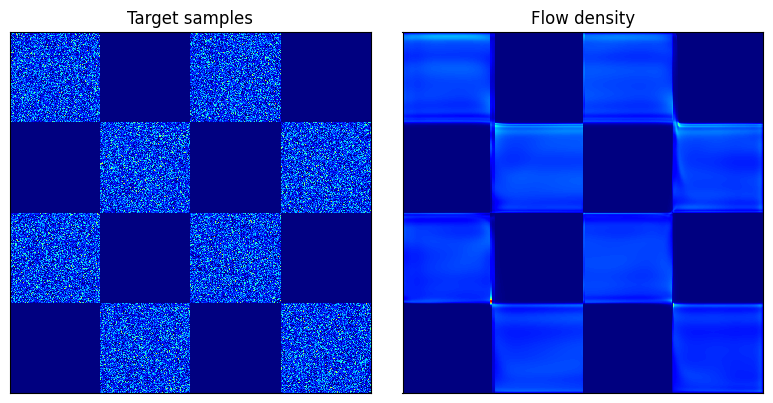

In [16]:
plot(model, potential_or_sampling_fn, args, show=True)